In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [3]:
from pathlib import Path
from torch.nn.functional import grid_sample
from deepshape.curves import *

In [4]:
class FuncApprox:
    def __init__(self, data):
        self.data = torch.zeros(1, 1, 1, data.shape[0])
        self.data[0, 0, 0, :] = data.squeeze()
        
    def __call__(self, x):
        grid = torch.zeros(1, 1, x.shape[0], 2)
        grid[0, 0, :, 0] = 2. * x.squeeze() - 1.
        return grid_sample(self.data, grid, padding_mode='border', align_corners=False, mode='bicubic').reshape(-1, 1)
    
    def _create_grid(self, x):
        if self.grid.shape[2] != x.view(-1).shape[0]:
            self.grid = torch.zeros(1, 1, x.shape[0], 2)
        self.grid[0, 0, :, 0] = 2. * x.squeeze() - 1.
        return self.grid

1. Start with matrix (n x s)
2. Create func-approx and resample to (n x k) matrix.
    3. From (n x k) matrix create n func-approximations (list of functions).
    4. Use single step karcher mean on n functions.
    5. Sample functions to a new (n x k) matrix.
    6. Check error vs. previous iteration. If sufficient improvement goto 3.
7. Resample.

? Questions ?
* 

# Generate Test Data

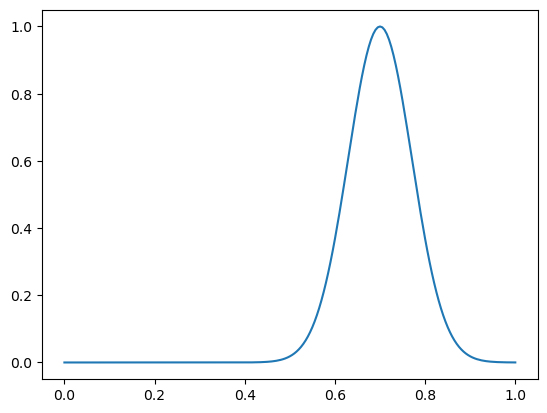

In [8]:
def sqnorm(x):
    return (x**2).sum(dim=-1)

def create_bump_function(amplitude, center, slope):
    return lambda x: amplitude * torch.exp(- slope**2 * sqnorm(x - center)).view(-1, 1)

x = col_linspace(0, 1, 201)
s = col_linspace(0, 1, 5)
f = create_bump_function(1., 0.7, 10)

plt.figure()
plt.plot(x, f(x))
plt.show()

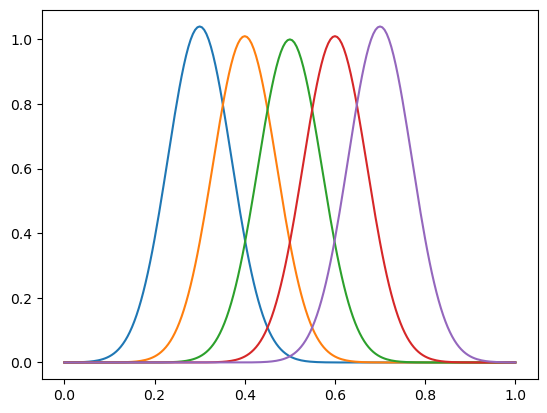

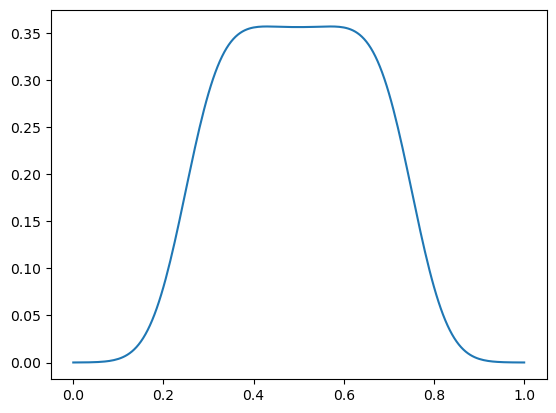

In [9]:
def create_bump_collection(N=5, slope_rand_scale=2.):
    c = np.linspace(0.3, 0.7, N)
    a = 1. * (c - 0.5)**2 + 1. 
    slope = 10 + slope_rand_scale * np.random.randn(N)
    return [
        create_bump_function(ai, ci, si) for ai, ci, si in zip(a, c, slope)
    ]

collection = create_bump_collection(5, 0.)
plt.figure()
for fi in collection:
    plt.plot(x, fi(x))
plt.show()

def linear_mean(function_collection):
    N = len(function_collection)
    def mean(x):
        return torch.hstack([fi(x) for fi in function_collection]).sum(dim=-1, keepdim=True) / N
    return mean

m = linear_mean(collection)
plt.figure()
plt.plot(x, m(x))
plt.show()

In [38]:
# def find_functional_center(f, k=512):
#     x = col_linspace(0, 1, k)
#     return (x * torch.abs(f(x))).sum() / torch.abs(f(x)).sum()

def find_functional_center(f, k=1024):
    x = col_linspace(0, 1, k)
    return f(x).mean()

def find_mean(f, k=512):
    x = col_linspace(0, 1, k)
    return (x * torch.abs(f(x))).sum() / torch.abs(f(x)).sum()

def find_functional_scale(f, k=512):
    x = col_linspace(0, 1, k)
    return torch.abs(f(x)).sum() / k

class FunctionalQmap:
    def __init__(self, f, centering=False, scaling=False):
        if centering:
            c = find_functional_center(f)
            if scaling:
                s = find_functional_scale(f)
                self.f = lambda x: (f(x) - c) / s
            else:
                self.f = lambda x: f(x) - c
        else:
            self.f = f
        
    def __call__(self, x, h=1e-4):
        Df = central_differences(self.f, x, h)
        return torch.sqrt(torch.abs(Df)+1e-8) * f(x)
#         return torch.sign(Df) * torch.sqrt(torch.abs(Df)+1e-8)

### Test Functional Matching

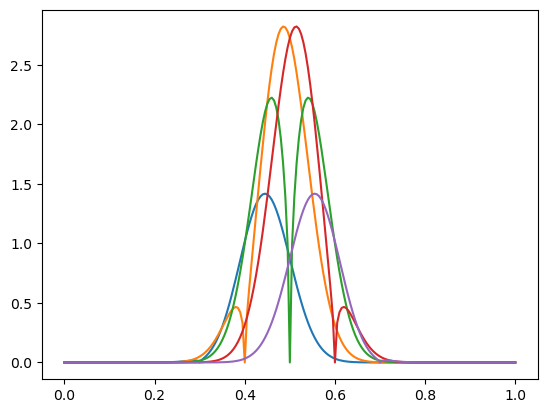


Finished training in 0.27975s


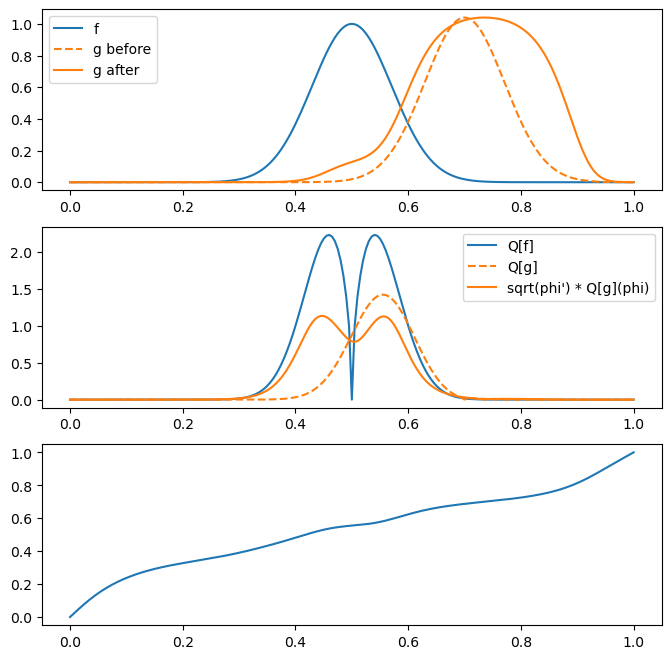

In [39]:
collection = create_bump_collection(5, 0.)
q_collection = [FunctionalQmap(fi, False, False) for fi in collection]

plt.figure()
for fi in q_collection:
    plt.plot(x, fi(x))
# plt.plot(x, FunctionalQmap(m, False, False)(x))
plt.show()


f, g = collection[2], collection[-1]
# f = m
q, r = FunctionalQmap(f, False, False), FunctionalQmap(g, False, False)
loss = CurveDistance(q, r, k=2048)
RN = CurveReparametrizer([
    SineSeries(5) for _ in range(5)
])
opt = torch.optim.LBFGS(RN.parameters(), line_search_fn='strong_wolfe', max_iter=100, max_eval=200)
error = reparametrize(RN, loss, opt, 1, Logger(0))

with torch.no_grad():
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))
    ax1.plot(x, f(x), label='f')
    ax1.plot(x, g(x), c='C1', ls='--', label='g before')
    ax1.plot(x, g(RN(x)), c='C1', label='g after')
    ax1.legend()
    
    ax2.plot(x, q(x), label='Q[f]')
    ax2.plot(x, r(x), c='C1', ls='--', label='Q[g]')
    ax2.plot(x, torch.sqrt(RN.derivative(x)) * r(RN(x)), c='C1', label="sqrt(phi') * Q[g](phi)")
    ax2.legend()
    plot_diffeomorphism(RN, ax=ax3)
    plt.show()

1. Start with point collections
2. Create function representation of point collections
3. Reparametrize.
4. Resample function representations.



Finished training in 0.09853s

Finished training in 0.06574s

Finished training in 0.05667s

Finished training in 0.09549s

Finished training in 0.00247s

Finished training in 0.08284s

Finished training in 0.03473s

Finished training in 0.07742s

Finished training in 0.05040s

Finished training in 0.09259s

Finished training in 0.06215s

Finished training in 0.13984s

Finished training in 0.08370s

Finished training in 0.08210s

Finished training in 0.05109s


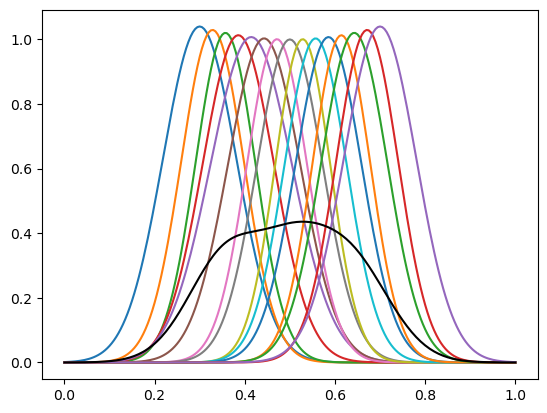

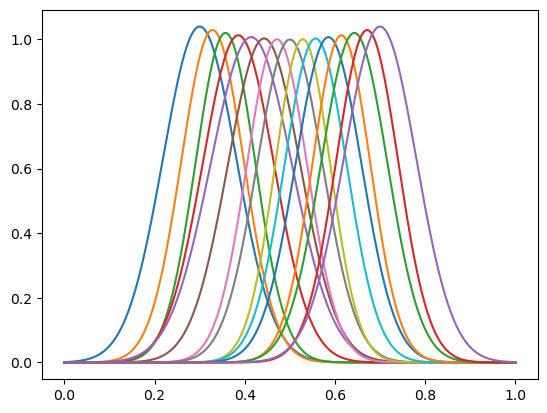

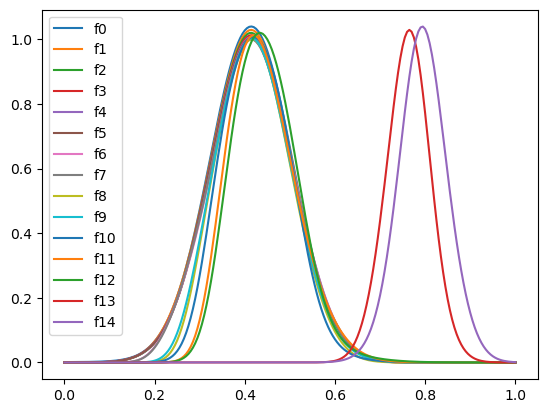

In [20]:
def torch_mse(x1, x2):
    return ((x1 - x2)**2).sum() / x1.shape[0]

def find_best_representative(q_collection):
    N = len(q_collection)
    d = np.inf * np.ones(N)
    x = col_linspace(0, 1, 512)
    m = linear_mean(q_collection)(x)
    for i, qi in enumerate(q_collection):
        d[i] = ((qi(x) - m)**2).sum()
    return np.argmin(d)


def karcher_mean_step(f_collection):
    q_collection = [FunctionalQmap(fi) for fi in f_collection]
    j = find_best_representative(q_collection)
    mu = q_collection[j]
#     mu = q_collection.pop(j)
    N = len(q_collection)

    RN = [
        CurveReparametrizer([
            SineSeries(1) for _ in range(1)
        ]) for _ in range(N)
    ]
    loss = [
        CurveDistance(mu, r, k=1024) for r in q_collection
    ]
    for i in range(N):
        opt = torch.optim.LBFGS(RN[i].parameters(), max_iter=100, line_search_fn='strong_wolfe')
        reparametrize(RN[i], loss[i], opt, 1, Logger(0))
    return j, RN


def karcher_mean_step(f_collection):
    q_collection = [FunctionalQmap(fi) for fi in f_collection]
    j = find_best_representative(q_collection)
    mu = q_collection[j]
#     mu = q_collection.pop(j)
    N = len(q_collection)

    RN = [
        CurveReparametrizer([
            SineSeries(10) for _ in range(1)
        ]) for _ in range(N)
    ]
    loss = [
        CurveDistance(mu, r, k=1024) for r in q_collection
    ]
    for i in range(N):
        opt = torch.optim.LBFGS(RN[i].parameters(), max_iter=100, line_search_fn='strong_wolfe')
        reparametrize(RN[i], loss[i], opt, 1, Logger(0))
    return j, RN
        

collection = create_bump_collection(15, 1.)
plt.figure()
for fi in collection:
    plt.plot(x, fi(x))

j, RNs = karcher_mean_step(collection)
m = linear_mean(collection)(x)

plt.plot(x, m, 'k')
plt.show()


plt.figure()
for fi in collection:
    plt.plot(x, fi(x))
plt.show()

with torch.no_grad():
    plt.figure()
    for i, rn in enumerate(RNs):
        plt.plot(x, collection[i](rn(x)), label=f"f{i}")
    plt.legend()
    plt.show()

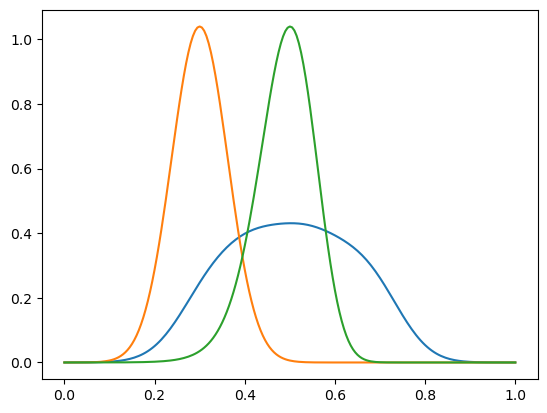

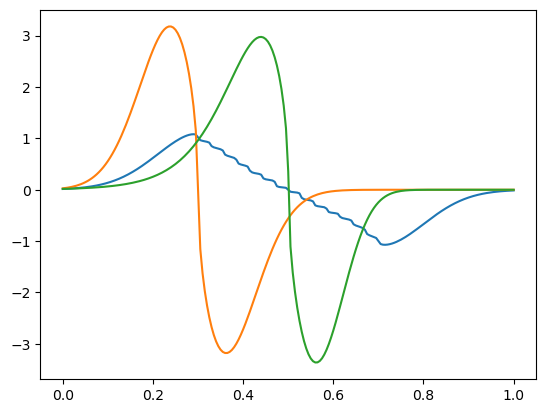

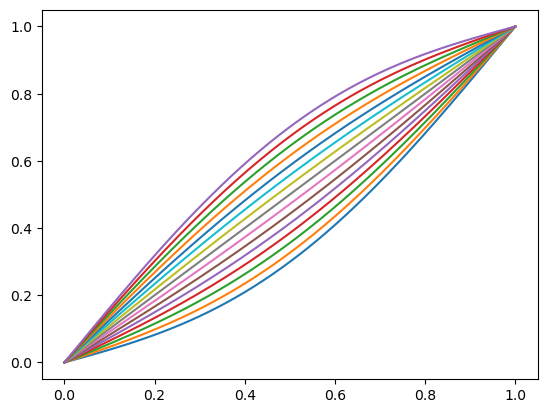

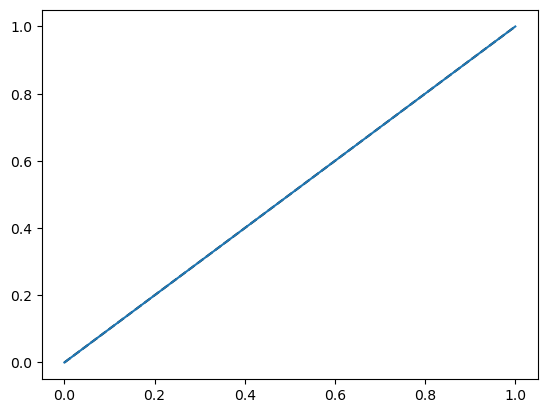

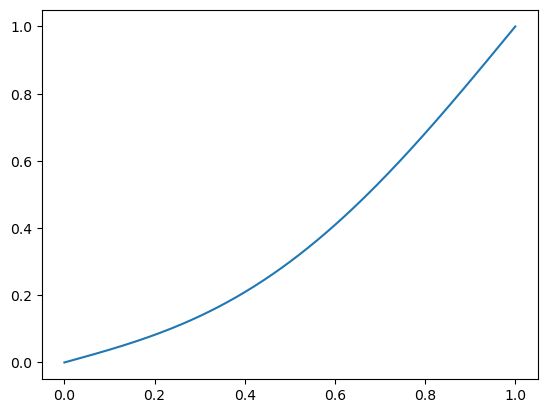

In [14]:
i=0
with torch.no_grad():
    q_collection = [FunctionalQmap(fi) for fi in collection]
    plt.plot(x, m)
    plt.plot(x, collection[i](x))
    plt.plot(x, collection[i](RNs[i](x)))
    plt.show()
    
    plt.plot(x, linear_mean(q_collection)(x))
    plt.plot(x, q_collection[i](x))
    plt.plot(x, torch.sqrt(RNs[i].derivative(x)) * q_collection[i](RNs[i](x)))
    plt.show()
    
    [plt.plot(x, rni(x)) for rni in RNs]
    plt.show()
    plt.plot(x, x, 'k--')
    plt.plot(x, linear_mean(RNs)(x))
    plt.show()

plot_diffeomorphism(RNs[i])
plt.show()